<a href="https://colab.research.google.com/github/pagutierrez/arow_csc/blob/master/chapter08_intro-to-dl-for-computer-vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Este cuaderno está basado en los cuadernos del libro [Deep Learning with Python, Second Edition](https://www.manning.com/books/deep-learning-with-python-second-edition?a_aid=keras&a_bid=76564dff).

> This is a companion notebook for the book [Deep Learning with Python, Second Edition](https://www.manning.com/books/deep-learning-with-python-second-edition?a_aid=keras&a_bid=76564dff). For readability, it only contains runnable code blocks and section titles, and omits everything else in the book: text paragraphs, figures, and pseudocode.
> **If you want to be able to follow what's going on, I recommend reading the notebook side by side with your copy of the book.**
> This notebook was generated for TensorFlow 2.6.

# Introducción a aprendizaje profundo para visión por computador

Las redes CNN son actualmente el estado del arte en visión por computador y han desbancado a otras opciones tradicionales.

## Introducción a las redes CNN

Vamos a comenzar construyendo una red CNN simple para la base de datos de clasificación de dígitos MNIST, una tarea que ya habéis visto en esta asignatura y en la que obtuvistéis alrededor del 98% de precisión usando redes completamente conectadas.

**Generando una red CNN simple**

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(inputs)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(10, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

Como se puede observar, la red es un concatenación de capas `Conv2D` y `MaxPooling2D`. Un red CNN suele aceptar como entrada tensores del tipo `(image_height, image_width,image_channels)`, lo que se traduce en `(28,28,1)` para este conjunto de datos.

**Mostrar el resumen del modelo**

In [ ]:
model.summary()

Se observa como la salida de estas capas especiales es de tipo `(height, width, channels)`, de manera que, conforme avanzamos en la red, el alto y el ancho va disminuyendo y el número de canales (que está impuesto por el número de filtros que ponemos en cada capa) va aumentando. Después de la última capa convolucional, tenemos 128 canales de 3x3 píxeles. Cada canal se convierte en un vector de 9 valores y todos se concatenan (capa `Flatten`), para finalmente aplicar una capa completamente conectada.

**Entrenar la CNN en las imágenes MNIST**

In [ ]:
from tensorflow.keras.datasets import mnist

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = train_images.reshape((60000, 28, 28, 1))
train_images = train_images.astype("float32") / 255
test_images = test_images.reshape((10000, 28, 28, 1))
test_images = test_images.astype("float32") / 255
model.compile(optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"])
model.fit(train_images, train_labels, epochs=5, batch_size=64)

**Evaluando la red construida**

In [ ]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f"Test accuracy: {test_acc:.3f}")

En solo 5 épocas obtenemos resultados de más de 99% de precisión.

### La operación de convolución

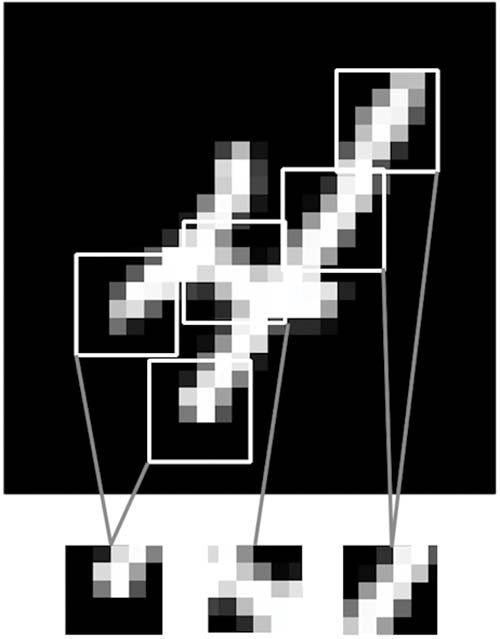

[Fuente imagen Collet 2022]

La diferencia fundamental entre una capa densamente conectada y una capa de convolución es la siguiente: las capas densas aprenden patrones globales en su espacio de características de entrada (por ejemplo, para un dígito MNIST, patrones que implican a todos los píxeles), mientras que las capas de convolución aprenden patrones locales -en el caso de las imágenes, patrones que se encuentran en pequeñas ventanas 2D de las entradas. En el ejemplo anterior, estas ventanas eran todas de `3×3`.

Esto proporciona a las CNN dos características fundamentales en su desempeño e ideales para tratar imágenes:
- *Los patrones que aprenden son invariantes respecto a la traslación*. Tras aprender un determinado patrón en la esquina inferior derecha de una imagen, una CNN puede reconocerlo en cualquier lugar: por ejemplo, en la esquina superior izquierda. Un modelo densamente conectado tendría que aprender el patrón de nuevo si apareciera en una nueva ubicación. Esto hace que las CNNs sean eficientes en el procesamiento de datos de imágenes (porque el mundo visual es fundamentalmente invariante de la traslación): necesitan menos muestras de entrenamiento para aprender representaciones que tengan poder de generalización.
- *Pueden aprender jerarquías espaciales de patrones*. Una primera capa de convolución aprenderá pequeños patrones locales, como bordes, una segunda capa de convolución aprenderá patrones más grandes formados por las características de las primeras capas, y así sucesivamente. Esto permite a las redes de convolución aprender de forma eficaz conceptos visuales cada vez más complejos y abstractos, ya que el mundo visual es fundamentalmente jerárquico desde el punto de vista espacial.

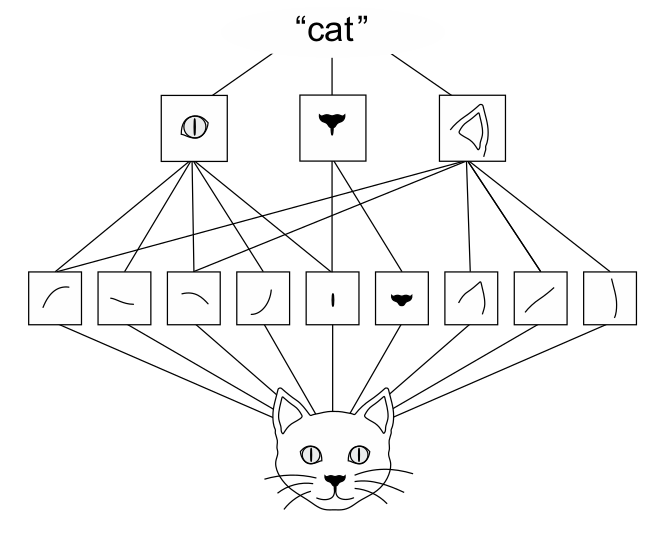

[Fuente imagen Collet 2022]

Las operaciones de convolución se basan en filtros entrenables, normalmente con dimensiones `3x3` o `5x5`. Sin embargo, si la imagen es RGB (es decir, contiene información de color) estos filtros tendrán una profundidad de 3 dimensiones. Los filtros buscan un determinado patrón en la imagen.

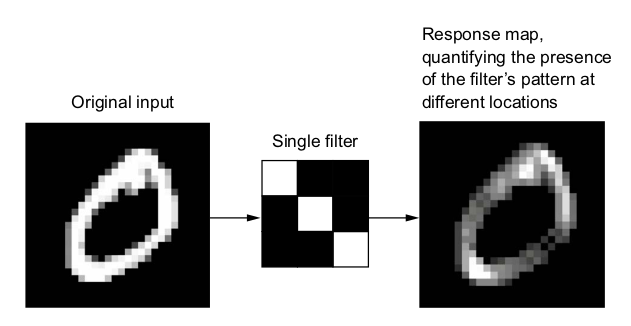

[Fuente Imagen Collet 2022]

#### Como tratar los bordes de la imagen (opción de relleno)

En principio, los filtros no podría aplicarse en los bordes de la imagen, ya que superaríamos (por exceso o por defecto) los límites de la misma. Observa como en nuestra red sencilla para MNIST, la capa Conv2D generaba un mapa de `26x26`.

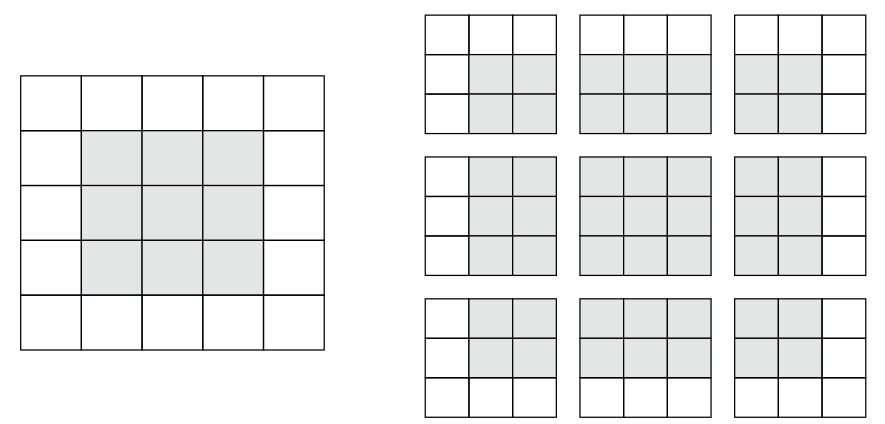

[Fuente imagen Collet 2022]

Una posibilidad alternativa a reducir las dimensiones de la imagen es usar *Padding* o relleno, es decir, incluir píxeles artificiales en los bordes que se suelen poner a cero.

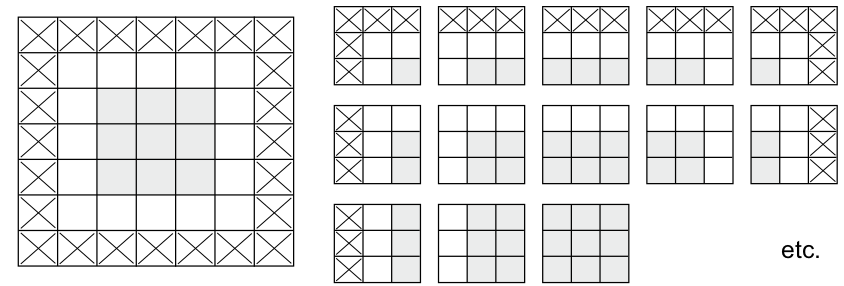

[Fuente imagen Chollet 2022]

Cuando usamos las capas `Conv2D` esto lo configuramos con el argumento `padding`, que puede tomar valores:
- `valid`: no se aplica padding y se reduce el tamaño.
- `same`: incluir el padding necesario para que el tamaño termine siendo el mismo.

#### Zancada o *stride*

Al aplicar el filtro, podemos ir avanzando píxel a píxel, es decir, que todas las ventanas sean continuas. Esto sería similar a dar zancadas (*strides*) de valor 1. Sin embargo, el valor de *stride* podría incrementarse, lo que reduciría el tamaño del mapa generado por cada filtro.

Convolución `3x3` con `stride=2`

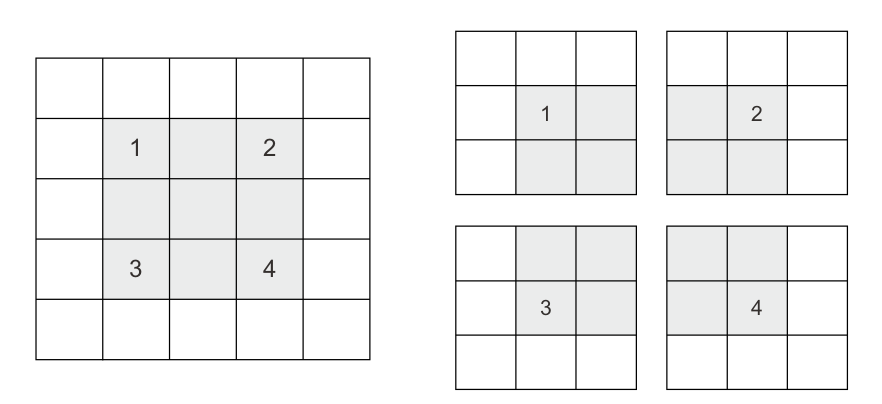

[Fuente imagen Chollet 2022]

Sin embargo, lo habitual (y más recomendable) es aplicar algún tipo de *pooling* para ir reduciendo el tamaño de los mapas y dejar `stride=1`.

### La operación de max-pooling

Habrá observado como el tamaño de los mapas del ejemplo de MNIST se reduce a la mitad cada vez que aplicamos la capa `MaxPooling2D`. ¿Por qué?

El max-pooling consiste en extraer ventanas del mapa de entrada y devolver el máximo de cada ventana, siendo similar a un filtro que siempre calcula el máximo (sin pesos que entrenar) y que se suele aplicar con dimensión `2x2` y con `stride=2.

¿Por qué hacer esto? Otra opción sería ir aplicando las capas de convolución sin reducir los tamaños (o simplemente con la reducción que conlleva la aplicación del filtro.

**Red CNN incorrectamente configuranda sin capas de max-pooling**

In [ ]:
inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(inputs)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(10, activation="softmax")(x)
model_no_max_pool = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
model_no_max_pool.summary()

¿Qué tiene de malo esta configuración? Dos cosas:
- No es propicio para el aprendizaje de una jerarquía espacial de características. Las ventanas de `3×3` de la tercera capa sólo contendrán información procedente de las ventanas de `7×7` de la entrada inicial. Los patrones de alto nivel aprendidos por la CNN seguirán siendo muy pequeños con respecto a la entrada inicial, lo que puede no ser suficiente para aprender a clasificar dígitos (**¡intenta reconocer un dígito mirándolo sólo a través de ventanas de 7 × 7 píxeles!**). Necesitamos que las características de la última capa de convolución contengan información sobre la totalidad de la entrada.
- El mapa de características final tiene `22×22×128 = 61.952` coeficientes totales por muestra. Esto es enorme. Si lo aplanamos para ponerle encima una capa densa de tamaño *10*, esa capa tendría más de medio millón de parámetros. Esto es demasiado para un modelo tan pequeño y daría lugar a un intenso sobreajuste.

En resumen, la razón para utilizar el downsampling es reducir el número de coeficientes del mapa de características que hay que procesar, así como inducir jerarquías de filtros espaciales haciendo que las capas de convolución exitosas analicen ventanas cada vez más grandes (en términos de la fracción de la entrada original que cubren).

Tened en cuenta que la agrupación de máximos no es la única forma de conseguir este tipo de reducción de la muestra. Como ya sabes, también puedes utilizar *strides* en la capa de convolución previa. Y se puede utilizar el pooling por promediado en lugar del pooling por máximo, donde cada parche de entrada local se transforma tomando el valor medio de cada canal sobre el parche, en lugar del máximo. Pero la agrupación máxima suele funcionar mejor que estas soluciones alternativas. La razón es que los rasgos tienden a codificar la presencia espacial de algún patrón o concepto en los diferentes mosaicos del mapa de características (de ahí el término mapa de rasgos), y es más informativo fijarse en la presencia máxima de los diferentes rasgos que en su presencia media. La estrategia de submuestreo más razonable es producir primero mapas densos de rasgos (mediante convoluciones sin *stride*) y luego observar la activación máxima de los rasgos en pequeños parches, en lugar de observar ventanas más dispersas de las entradas (mediante convoluciones con *stride*) o promediar parches de entrada, lo que podría hacer que se perdiera o diluyera información sobre la presencia de rasgos.

## Entrenando una CNN desde cero con un conjunto de datos pequeño

### La necesidad de afrontar problemas con conjuntos de datos pequeños

Tener que entrenar un modelo de clasificación de imágenes **con muy pocos datos** es una situación común, que probablemente encontrarás en la práctica si alguna vez te dedicas a la visión por ordenador en un contexto profesional. Unas «pocas» muestras pueden significar desde unos cientos hasta unas decenas de miles de imágenes. Como ejemplo práctico, nos centraremos en clasificar imágenes como perros o gatos en un conjunto de datos que contiene `5.000` imágenes de gatos y perros (`2.500` gatos, `2.500` perros). Utilizaremos `2.000` imágenes para el entrenamiento, `1.000` para la validación y `2.000` para las pruebas`

En esta sección, revisaremos una estrategia básica para abordar este problema: entrenar un nuevo modelo desde cero utilizando los pocos datos de los que se dispone. Empezaremos entrenando ingenuamente una pequeña CNN en las `2.000` muestras de entrenamiento, sin ninguna regularización, para establecer una línea base de lo que se puede conseguir. Esto nos llevará a una precisión de clasificación de alrededor del `70%`. En ese punto, el principal problema será el sobreajuste. Entonces introduciremos el aumento de datos, una poderosa técnica para mitigar el sobreajuste en la visión por ordenador. Utilizando el aumento de datos, mejoraremos el modelo para alcanzar una precisión del `80-85%`.

En la siguiente sección, revisaremos otras dos técnicas esenciales para aplicar el aprendizaje profundo a conjuntos de datos pequeños: la extracción de características con un modelo preentrenado (que nos llevará a una precisión del `97,5%`) y el ajuste fino de un modelo preentrenado (que nos llevará a una precisión final del `98,5%`). Juntas, estas tres estrategias -entrenar un modelo pequeño desde cero, realizar la extracción de características utilizando un modelo preentrenado y ajustar un modelo preentrenado- constituirán tu futura caja de herramientas para abordar el problema de la clasificación de imágenes con conjuntos de datos pequeños.

### Descargando los datos

Los datos que vamos a utilizar provienen de una competición de Kaggle de 2013, cuando las CNN no eran tan famosas.

Puedes descargar el conjunto de datos original en este [enlace](http://www.kaggle.com/c/dogs-vs-cats/data), después de haber creado un usuario.

También se puede hacer a través de la API de Kaggle, disponible en el paquete `kaggle`, que viene preinstalado en Colab. En todo caso, tendrás que crearte un usuario en Kaggle para poder acceder a dicha API.

Después de haberte creado el usuario, debes autenticarte a través de la API. El paquete `kaggle` buscará tus credenciales de acceso en un archivo JSON ubicado en `~/.kaggle/kaggle.json`. Vamos a crear este archivo.

En primer lugar, necesitas crear una clave API de Kaggle y descargarla en tu máquina local. Solo tienes que navegar por el sitio web de Kaggle en un navegador web, iniciar sesión e ir a la página `My account`. En la configuración de tu cuenta (`Settings`), encontrarás una sección API. Al hacer clic en el botón `Create new token` se generará un archivo de clave `kaggle.json` y se descargará localmente en tu máquina.


En segundo lugar, ve a tu cuaderno Colab y carga el archivo JSON de clave de API a tu sesión Colab ejecutando el siguiente código:

In [ ]:
from google.colab import files
files.upload()

Cuando ejecutes esta celda, verás que aparece un botón "Examinar". Haga clic en él y seleccione el archivo `kaggle.json` que acaba de descargar. Esto carga el archivo en el entorno de ejecución local de Colab (puedes verlo si accedes a `Archivos` en la barra izquierda de Colab.


Por último, crea una carpeta `~/.kaggle` copia el archivo de claves en ella. Como una mejor práctica de seguridad, nos aseguramos de que el archivo sólo es legible por el usuario actual:

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Por fin podemos descargar los datos que vamos a usar:

In [ ]:
!kaggle competitions download -c dogs-vs-cats

La primera vez que intentes descargar los datos, obtendrás un error `403 Forbidden`. Esto se debe a que tienes que aceptar los términos asociados con el conjunto de datos antes de descargarlo. Tendrás que ir a `www.kaggle.com/c/dogs-vs-cats/data` (mientras estás conectado a tu cuenta de Kaggle), unirte a la competición y hacer clic en el botón de aceptación de la competición. Sólo tienes que hacerlo una vez.

Los datos de entrenamiento están un archivo comprimido llamado `train.zip`. Los vamos a descomprimir en silencio (-qq):

In [ ]:
!unzip -qq dogs-vs-cats.zip

In [ ]:
!unzip -qq train.zip

A continuación puedes ver algunas ejemplos de las imágenes. Como puedes observar, las imágenes tienen distintos tamaños, colores, fondos, etc.

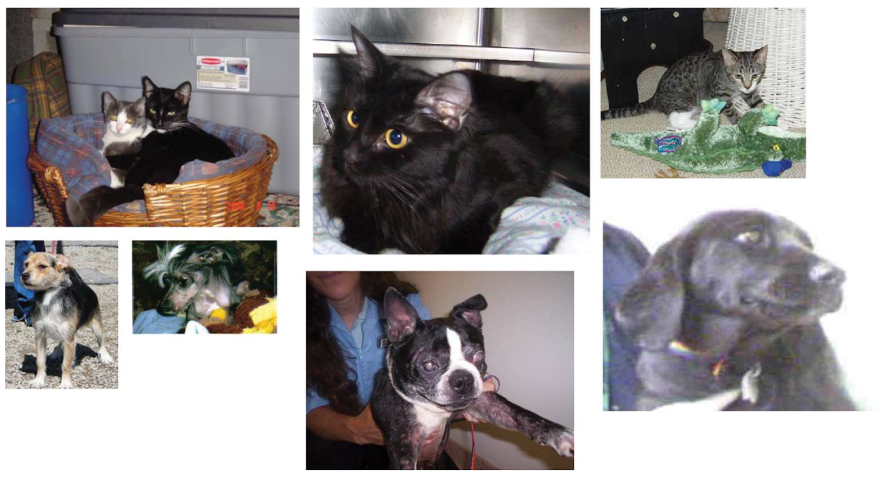

[Fuente imagen Collet 2022]

**Copiando los archivos a los directorios de entrenamiento, validación y test**

Aunque el conjunto de datos tiene `25.000` imágenes, vamos a utilizar un subconjunto para hacer el problema más tratable computacionalmente y al mismo tiempo más complejo y cercano al mundo real (no es habitual topar con bases de datos con tantas imágenes).

Por ello, el siguiente código crea una jerarquía de ficheros en la que tendremos `1.000` imágenes para entrenar, `500` para validar y `1.000` para testeo.

In [ ]:
import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2500)

### Construyendo el modelo

**Instantiating a small convnet for dogs vs. cats classification**

Reutilizaremos la misma estructura general del modelo que viste en el primer ejemplo: la red convolucional será una pila de capas alternadas de `Conv2D` (con activación `ReLU`) y `MaxPooling2D`.  

Pero, dado que estamos tratando con imágenes más grandes y un problema más complejo, ampliaremos nuestro modelo en consecuencia: tendrá dos etapas adicionales de `Conv2D` y `MaxPooling2D`. Esto sirve tanto para aumentar la capacidad del modelo como para reducir aún más el tamaño de los mapas de características, evitando que sean demasiado grandes cuando lleguemos a la capa `Flatten`.  

Aquí, dado que partimos de entradas de tamaño `180 x 180` píxeles (una elección algo arbitraria), terminamos con mapas de características de tamaño `7 x 7` justo antes de la capa `Flatten`. La profundidad de los mapas de características aumenta progresivamente en el modelo (de `32` a `256`), mientras que su tamaño disminuye (de `180 x 180` a `7 x 7`). Este es un patrón que verás en casi todas las redes convolucionales.  

**NOTA**  
Dado que estamos tratando con un problema de clasificación binaria, terminaremos el modelo con una única unidad (una capa `Dense` de tamaño `1`) y una activación `sigmoid`. Esta unidad codificará la probabilidad de que el modelo esté observando una clase u otra.  

Por último, una pequeña diferencia: comenzaremos el modelo con una capa de `Rescaling`, que reajustará los valores de entrada de las imágenes (originalmente en el rango `[0, 255]`) al rango `[0, 1]`.  


In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
model.summary()

**Configurando el modelos para el entrenamiento**

Para el paso de compilación, utilizaremos el optimizador `RMSprop`, como de costumbre. Dado que terminamos el modelo con una única unidad `sigmoid`, usaremos `binary_crossentropy` como función de pérdida.  


In [ ]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

### Preprocesado de datos

**Utilizando `image_dataset_from_directory` para leer imágenes**

Como ya sabes, los datos deben estar formateados en tensores de punto flotante apropiadamente preprocesados antes de ser alimentados al modelo. Actualmente, los datos están almacenados en un disco como archivos JPEG, por lo que los pasos para prepararlos y pasarlos al modelo son aproximadamente los siguientes:  
- Leer los archivos de imagen.  
- Decodificar el contenido `JPEG` en cuadrículas `RGB` de píxeles.  
- Convertirlos en tensores de punto flotante.  
- Redimensionarlos a un tamaño común (usaremos `180 x 180`).  
- Agruparlos en lotes (usaremos lotes de `32` imágenes).  

Puede parecer un proceso complicado, pero afortunadamente Keras tiene utilidades que se encargan de estos pasos automáticamente. En particular, Keras incluye la función `image_dataset_from_directory()`, que permite configurar rápidamente un flujo de datos que convierte automáticamente los archivos de imagen en disco en lotes de tensores preprocesados.  

Llamar a `image_dataset_from_directory(directory)` primero listará los subdirectorios dentro de `directory` y asumirá que cada uno contiene imágenes de una de nuestras clases. Luego indexará los archivos de imagen en cada subdirectorio. Finalmente, creará y devolverá un objeto `tf.data.Dataset` configurado para leer estos archivos y barajarlos.  


In [ ]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

#### Entendiendo los objetos `TensorFlow Dataset`

TensorFlow proporciona la API `tf.data` para crear flujos de entrada eficientes en modelos de aprendizaje automático. Su clase principal es `tf.data.Dataset`.  

Un objeto `Dataset` es un iterador: puedes usarlo en un bucle `for`. Normalmente, devolverá lotes de datos de entrada y etiquetas. Puedes pasar un objeto `Dataset` directamente al método `fit()` de un modelo en Keras.  

La clase `Dataset` maneja muchas características clave que de otro modo serían difíciles de implementar por tu cuenta, en particular, la prelectura asíncrona de datos (*prefetching*), que permite procesar el siguiente lote de datos mientras el modelo maneja el anterior, manteniendo la ejecución sin interrupciones.  

La clase `Dataset` también expone una API funcional para modificar conjuntos de datos. Aquí tienes un ejemplo rápido: vamos a crear una instancia de `Dataset` a partir de un array de NumPy con números aleatorios. Consideraremos `1,000` muestras, donde cada muestra es un vector de tamaño `16`:


In [ ]:
import numpy as np
import tensorflow as tf
random_numbers = np.random.normal(size=(1000, 16))
dataset = tf.data.Dataset.from_tensor_slices(random_numbers)

Al principio, nuestro dataset solo devuelve muestras individuales:

In [ ]:
for i, element in enumerate(dataset):
    print(element.shape)
    if i >= 2:
        break

Podemos usar el método .batch() para agrupar los datos en lotes:

In [ ]:
batched_dataset = dataset.batch(32)
for i, element in enumerate(batched_dataset):
    print(element.shape)
    if i >= 2:
        break

Más ampliamente, tenemos acceso a una serie de métodos útiles en `Dataset`, tales como:
- `.shuffle(buffer_size)`: Mezcla elementos dentro de un búfer.
- `.prefetch(buffer_size)`: Prelectura de elementos en memoria GPU para mejorar la utilización del dispositivo.
- `.map(callable)`: Aplica una transformación arbitraria a cada elemento del dataset (donde `callable` es una función que espera recibir como entrada un solo elemento del dataset).

El método `.map()` es especialmente útil y lo usarás con frecuencia. Aquí tienes un ejemplo: usaremos `.map()` para remodelar los elementos de nuestro dataset de forma (16,) a (4, 4):

In [ ]:
reshaped_dataset = dataset.map(lambda x: tf.reshape(x, (4, 4)))
for i, element in enumerate(reshaped_dataset):
    print(element.shape)
    if i >= 2:
        break

**Mostrando los `shapes` y las etiquetas del `Dataset`**

Miremos la salida de uno de estos objetos `Dataset`: devuelve lotes de imágenes `RGB` de `180 x 180` (con forma `(32, 180, 180, 3)`) y etiquetas enteras (con forma `(32,)`). Hay `32` muestras en cada lote (el tamaño del lote).  


In [ ]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

**Ajustar el modelo mediante un `Dataset`**

Vamos a ajustar el modelo en nuestro conjunto de datos. Utilizaremos el argumento `validation_data` en `fit()` para monitorizar las métricas de validación en un objeto `Dataset` separado.  

Ten en cuenta que también utilizaremos un *callback* `ModelCheckpoint` para guardar el modelo después de cada época. Lo configuraremos con la ruta que especifica dónde guardar el archivo, así como los argumentos `save_best_only=True` y `monitor="val_loss"`: estos le indican al *callback* que solo guarde un nuevo archivo (sobrescribiendo cualquier archivo anterior) cuando el valor actual de la métrica `val_loss` sea más bajo que en cualquier momento previo durante el entrenamiento. Esto garantiza que el archivo guardado siempre contendrá el estado del modelo correspondiente a su mejor época de entrenamiento, en términos de su rendimiento en los datos de validación. Como resultado, no tendremos que volver a entrenar un modelo por un menor número de épocas si comenzamos a sobreajustar: simplemente podemos volver a cargar el archivo guardado.


In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

**NOTA**: Este entrenamiento llevará mucho tiempo, puedes bajarlo a una época. Incluiremos el resultado esperado para 30 épocas en las siguientes celdas para que no tengas que realizarlo.

**Mostrando las curvas de la pérdida y la precisión durante el entrenamiento**

In [ ]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

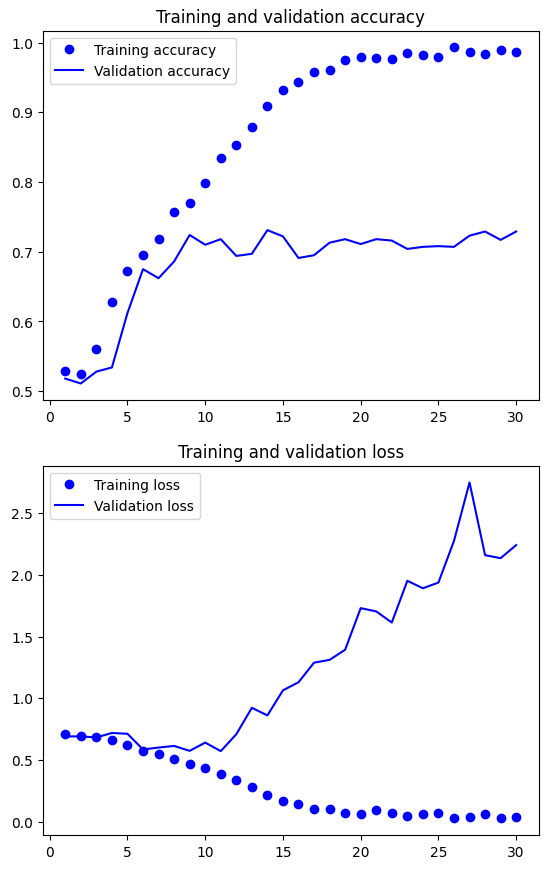

Estos gráficos son característicos del sobreajuste. La precisión en el entrenamiento aumenta linealmente con el tiempo, hasta alcanzar casi el `100%`, mientras que la precisión en la validación alcanza su punto máximo en el `75%`. La pérdida de validación llega a su mínimo después de solo diez épocas y luego se estabiliza, mientras que la pérdida de entrenamiento sigue disminuyendo linealmente a medida que avanza el entrenamiento.


**Evaluando el modelo en el conjunto de test**

Vamos a comprobar la precisión en el conjunto de test. Recargaremos el modelo desde su archivo guardado para evaluarlo tal como estaba antes de comenzar a sobreajustar.

In [ ]:
test_model = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

Obtenemos una precisión en la prueba de `72.9%` (debido a la aleatoriedad de las inicializaciones de redes neuronales, podrías obtener números dentro de un punto porcentual de ese valor).  

Debido a que tenemos relativamente pocas muestras de entrenamiento (`2,000`), el sobreajuste será nuestra principal preocupación. Ya conoces varias técnicas que pueden ayudar a mitigar el sobreajuste, como el *dropout* y la decaimiento de pesos (regularización L2). Ahora vamos a trabajar con una nueva técnica, específica para visión por computadora y usada casi universalmente cuando se procesan imágenes con modelos de aprendizaje profundo: el **aumento de datos**.


### Utilizando el aumento de datos (*data augmentation*)

El sobreajuste es causado por tener demasiadas pocas muestras para aprender, lo que te impide entrenar un modelo que pueda generalizar a nuevos datos. Dado un número infinito de datos, tu modelo estaría expuesto a todos los aspectos posibles de la distribución de los datos en cuestión: nunca sobreajustarías.  

El aumento de datos sigue el enfoque de generar más datos de entrenamiento a partir de las muestras de entrenamiento existentes, mediante la aplicación de una serie de transformaciones aleatorias que producen imágenes que parecen creíbles. El objetivo es que, durante el entrenamiento, tu modelo nunca vea la misma imagen exacta dos veces. Esto ayuda a exponer al modelo a más aspectos de los datos, lo que le permite generalizar mejor.


**Definir una fase de aumento de datos para añadir al modelo**

En Keras, esto se puede hacer agregando varias capas de aumento de datos al inicio de tu modelo. Comencemos con un ejemplo: el siguiente modelo `Sequential` encadena varias transformaciones aleatorias de imágenes. En nuestro modelo, lo incluiríamos justo antes de la capa `Rescaling`.

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

Estas son solo algunas de las capas disponibles (para más, consulta la documentación de Keras). Vamos a repasar rápidamente este código:

- `RandomFlip("horizontal")` — Aplica un volteo horizontal aleatorio al 50% de las imágenes que lo atraviesan.
- `RandomRotation(0.1)` — Rota las imágenes de entrada por un valor aleatorio en el rango `[–10%, +10%]` (estos son fracciones de un círculo completo; en grados, el rango sería `[–36 grados, +36 grados]`).
- `RandomZoom(0.2)` — Hace un zoom hacia adentro o hacia afuera de la imagen por un factor aleatorio en el rango `[-20%, +20%]`.

**Mostrando algunas imágenes aumentadas**

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1): # Solo se muestra una imagen
    for i in range(9): # Le hacemos 9 transformaciones
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

Si entrenamos un nuevo modelo usando esta configuración de aumento de datos, el modelo nunca verá la misma entrada dos veces. Pero las entradas que ve son todavía fuertemente intercorrelacionadas porque provienen de un pequeño número de imágenes originales; no podemos producir nueva información, solo podemos remezclar la información existente. Como tal, esto puede no ser suficiente para eliminar completamente el sobreajuste. Para combatir aún más el sobreajuste, también agregaremos una capa `Dropout` a nuestro modelo justo antes del clasificador densamente conectado.  

Una última cosa que debes saber sobre las capas de aumento aleatorio de imágenes: al igual que el `Dropout`, están inactivas durante la inferencia (cuando llamamos a `predict()` o `evaluate()`). Durante la evaluación, nuestro modelo se comportará de la misma manera que cuando no incluía aumento de datos ni `dropout`.

**Definiendo una nueva CNN que tiene aumento de datos y dropout**

In [ ]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

**Entrenando la CNN regularizada**

Ahora vamos a ir a más épocas, ya que esperamos que gracias a estas técnicas se reduzca el sobre ajuste.

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=validation_dataset,
    callbacks=callbacks)

In [ ]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

Estos son los resultados que obtendrías (aproximadamente) si completas el entrenamiento:

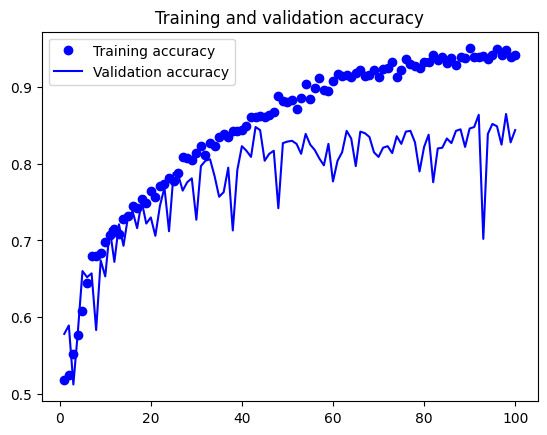

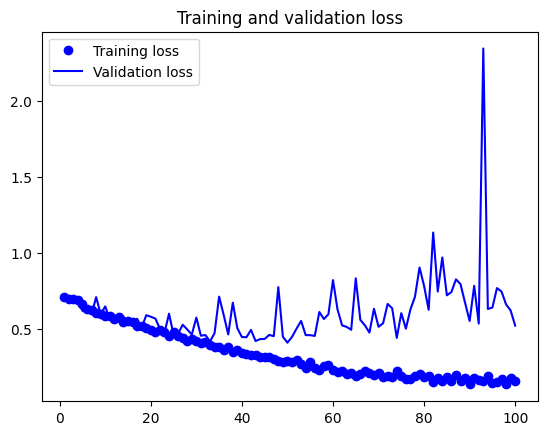

**Evaluando el modelo en el conjunto de test**

In [ ]:
test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

Obtenemos una precisión en la prueba de `81.7%`. ¡Está empezando a verse bien! Si estás usando Colab, asegúrate de descargar el archivo guardado (`convnet_from_scratch_with_augmentation.keras`).  

Al ajustar aún más la configuración del modelo (como el número de filtros por capa de convolución o el número de capas en el modelo), podríamos ser capaces de obtener una precisión aún mejor, probablemente hasta el `90%`. Pero sería difícil llegar más alto solo entrenando nuestra propia red convolucional desde cero, porque tenemos tan pocos datos con los que trabajar. Como siguiente paso para mejorar nuestra precisión en este problema, tendremos que usar un modelo preentrenado, que es el enfoque del resto del cuaderno.


## Aprovechando un modelo pre-entrenado

Un enfoque común y altamente efectivo para el aprendizaje profundo en pequeños conjuntos de datos de imágenes es usar un modelo preentrenado. Un modelo preentrenado es un modelo que fue previamente entrenado en un gran conjunto de datos, típicamente en una tarea de clasificación de imágenes a gran escala. Si este conjunto de datos original es lo suficientemente grande y general, la jerarquía espacial de características aprendidas por el modelo preentrenado puede actuar efectivamente como un modelo genérico del mundo visual, y por lo tanto, sus características pueden resultar útiles para muchos problemas diferentes de visión por computadora, incluso si estos nuevos problemas involucran clases completamente distintas a las del problema original.  

Por ejemplo, podrías entrenar un modelo en *ImageNet* (donde las clases son principalmente animales y objetos cotidianos) y luego reutilizar este modelo entrenado para algo tan diferente como identificar muebles en imágenes. Esta portabilidad de las características aprendidas a través de diferentes problemas es una ventaja clave del aprendizaje profundo en comparación con muchos enfoques anteriores y más superficiales, y hace que el aprendizaje profundo sea muy efectivo para problemas con pocos datos.  

En este caso, consideremos una gran red convolucional entrenada en el conjunto de datos *ImageNet* (1.4 millones de imágenes etiquetadas y 1,000 clases diferentes). *ImageNet* contiene muchas clases de animales, incluidas diferentes especies de gatos y perros, por lo que puedes esperar que funcione bien en el problema de clasificación de perros contra gatos.  

Usaremos la arquitectura `VGG16`, desarrollada por Karen Simonyan y Andrew Zisserman en 2014. Aunque es un modelo más antiguo, lejos del estado del arte actual y algo más pesado que muchos modelos recientes, lo elegí porque su arquitectura es similar a lo que ya conoces y es fácil de entender sin introducir nuevos conceptos. Esta puede ser tu primera experiencia con uno de estos nombres llamativos de modelos: `VGG`, `ResNet`, `Inception`, `Xception`, y así sucesivamente; te acostumbrarás a ellos porque aparecerán con frecuencia si sigues trabajando en aprendizaje profundo para visión por computadora.  

Hay dos formas de usar un modelo preentrenado: extracción de características y ajuste fino. Cubriremos ambas. Comencemos con la extracción de características.

### Extracción de características con un modelo pre-entrenado

### Extracción de características

La extracción de características consiste en utilizar las representaciones aprendidas por un modelo previamente entrenado para extraer características interesantes de nuevas muestras. Estas características luego se pasan a través de un nuevo clasificador, que se entrena desde cero.  

Como viste anteriormente, las redes convolucionales (CNNs) utilizadas para la clasificación de imágenes se componen de dos partes: comienzan con una serie de capas de convolución y agrupamiento, y terminan con un clasificador densamente conectado. La primera parte se llama la base convolucional del modelo. En el caso de las CNNs, la extracción de características consiste en tomar la base convolucional de una red previamente entrenada, pasar los nuevos datos a través de ella y entrenar un nuevo clasificador sobre la salida.  

¿Por qué reutilizar solo la base convolucional? ¿Podríamos reutilizar también el clasificador densamente conectado? En general, esto debería evitarse. La razón es que las representaciones aprendidas por la base convolucional son probablemente más genéricas y, por lo tanto, más reutilizables: los mapas de características de una CNN son mapas de presencia de conceptos genéricos en una imagen, lo que probablemente sea útil independientemente del problema de visión por computadora en cuestión. Pero las representaciones aprendidas por el clasificador serán necesariamente específicas del conjunto de clases en el que se entrenó el modelo; solo contendrán información sobre la probabilidad de presencia de esta o aquella clase en la imagen completa.  

Además, las representaciones encontradas en las capas densamente conectadas ya no contienen información sobre dónde se encuentran los objetos en la imagen de entrada; estas capas eliminan la noción de espacio, mientras que la ubicación de los objetos todavía está descrita por los mapas de características convolucionales. Para problemas donde la ubicación de los objetos es importante, las características densamente conectadas son en gran medida inútiles.  

Ten en cuenta que el nivel de generalidad (y, por lo tanto, reutilización) de las representaciones extraídas por capas de convolución específicas depende de la profundidad de la capa en el modelo. Las capas que están más cerca del inicio del modelo extraen mapas de características locales y altamente genéricas (como bordes visuales, colores y texturas), mientras que las capas más profundas extraen conceptos más abstractos (como “oreja de gato” o “ojo de perro”). Por lo tanto, si tu nuevo conjunto de datos difiere mucho del conjunto de datos en el que se entrenó el modelo original, podrías obtener mejores resultados utilizando solo las primeras capas del modelo para la extracción de características, en lugar de usar toda la base convolucional.  

En este caso, dado que el conjunto de clases de ImageNet contiene múltiples clases de perros y gatos, es probable que sea beneficioso reutilizar la información contenida en las capas densamente conectadas del modelo original. Sin embargo, elegiremos no hacerlo para cubrir el caso más general donde el conjunto de clases del nuevo problema no coincide con el conjunto de clases del modelo original. Pongamos esto en práctica utilizando la base convolucional de la red `VGG16`, entrenada en ImageNet, para extraer características interesantes de imágenes de gatos y perros, y luego entrenar un clasificador de perros contra gatos sobre estas características.  

El modelo `VGG16`, entre otros, viene preempaquetado con Keras. Puedes importarlo desde el módulo `keras.applications`. Muchos otros modelos de clasificación de imágenes (todos entrenados en el conjunto de datos ImageNet) están disponibles como parte de `keras.applications`:  

- `Xception`  
- `ResNet`  
- `MobileNet`  
- `EfficientNet`  
- `DenseNet`  
- etc.  

Vamos a instanciar el modelo `VGG16`.



**Instanciando la base convolucional VGG16**

In [ ]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet", #Checkpoint de los pesos de Imagenet
    include_top=False, #Incluir o no la capa final
    input_shape=(180, 180, 3))

In [ ]:
conv_base.summary()

#### Extracción rápida de características sin aumento de datos

**Extrayendo las características de VGG16 y las etiquetas a predecir**

In [ ]:
import numpy as np

def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

In [ ]:
train_features.shape

**Definimos y entrenamos una red densa para clasificar esas características**

In [ ]:
inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
      filepath="feature_extraction.keras",
      save_best_only=True,
      monitor="val_loss")
]
history = model.fit(
    train_features, train_labels,
    epochs=20,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)

**Mostrar los resultados de nuestra red densa**

In [ ]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

Deberías ver estos resultados:

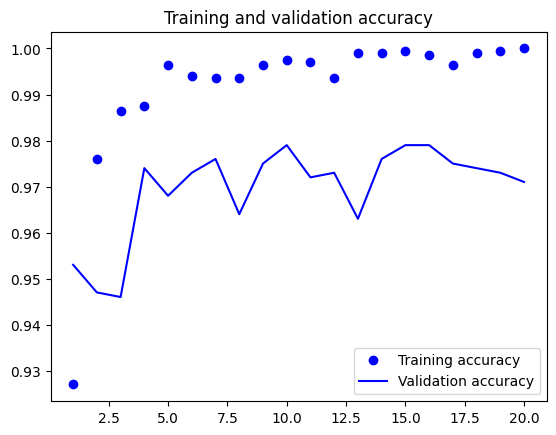

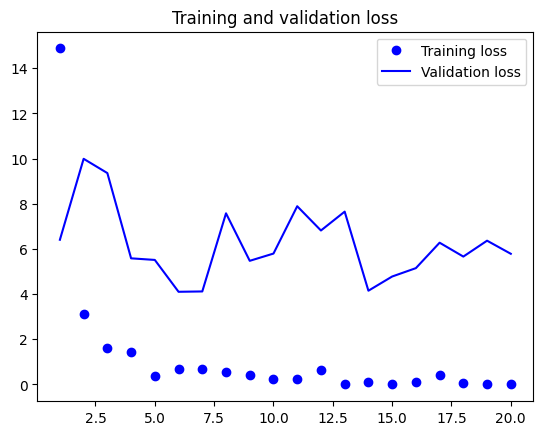

#### Extracción de características junto con aumento de datos

**Instanciar y congerlar VGG16**

In [ ]:
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)
conv_base.trainable = False # Esto hace que esa parte de la red no se entrene

**Mostrar cuáles son los pesos entrenables después de haber congelado**

In [ ]:
conv_base.trainable = True
print("Este es el número de pesos entrenables antes de congelar",
      len(conv_base.trainable_weights))

In [ ]:
conv_base.trainable = False
print("Este es el número de pesos entrenables después de congelar",
      len(conv_base.trainable_weights))

**Añadir el clasificador junto con una fase de aumento de datos**

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction_with_data_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks)

In [ ]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

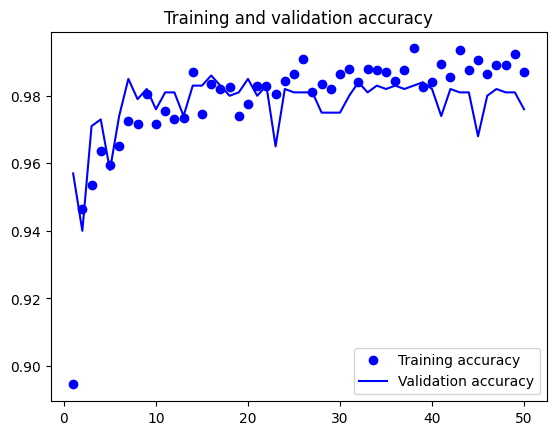

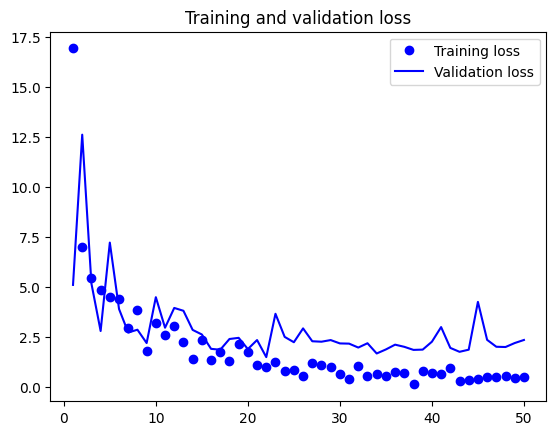

**Evaluando el modelo de en el conjunto de test**

In [ ]:
test_model = keras.models.load_model(
    "feature_extraction_with_data_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

Hemos llegado a un 98% en test.

### Ajustando en grano fino un modelo pre-entrenado (fine-tuning)

In [ ]:
conv_base.summary()

### Ajuste fino de las capas finales

Ajustaremos las últimas tres capas convolucionales, lo que significa que todas las capas hasta `block4_pool` deben estar congeladas, y las capas `block5_conv1`, `block5_conv2` y `block5_conv3` deben ser entrenables.  

¿Por qué no ajustar más capas? ¿Por qué no ajustar toda la base convolucional?  
Podrías hacerlo, pero necesitas considerar lo siguiente:  

- Las capas más tempranas en la base convolucional codifican características más genéricas y reutilizables, mientras que las capas más profundas codifican características más especializadas. Es más útil ajustar las características especializadas, ya que son las que necesitan adaptarse al nuevo problema. Ajustar capas más tempranas tendría rendimientos rápidamente decrecientes.  
- Cuantos más parámetros estés entrenando, mayor es el riesgo de sobreajuste. La base convolucional tiene 15 millones de parámetros, por lo que sería arriesgado intentar entrenarla en tu pequeño conjunto de datos.  

Por lo tanto, en esta situación, una buena estrategia es ajustar solo las dos o tres capas superiores en la base convolucional. Vamos a configurarlo, partiendo de donde lo dejamos en el ejemplo anterior.

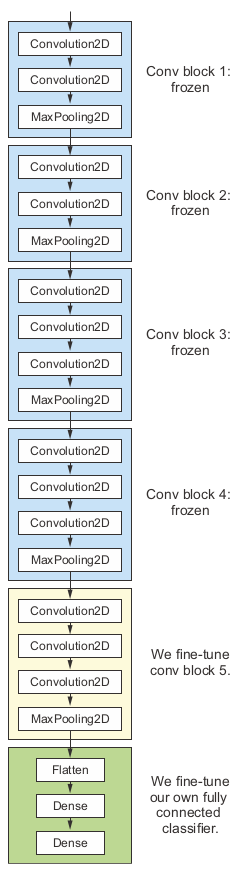

[Fuente de imagen: Chollet 2022]


**Congelando todas las capas hasta la cuarta empezando por el final**

In [ ]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

**Refinando el modelo**

In [ ]:
model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="fine_tuning.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

In [ ]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

Deberías ver algo así:

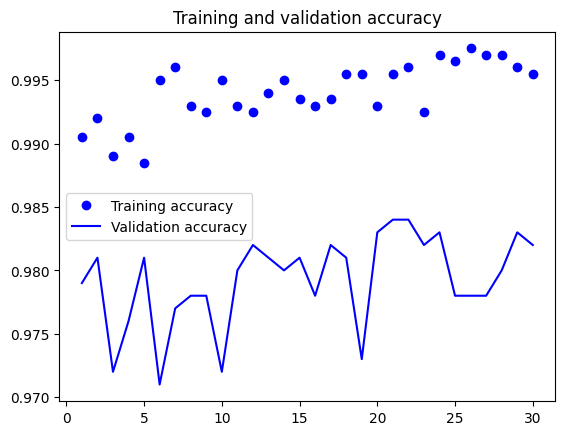


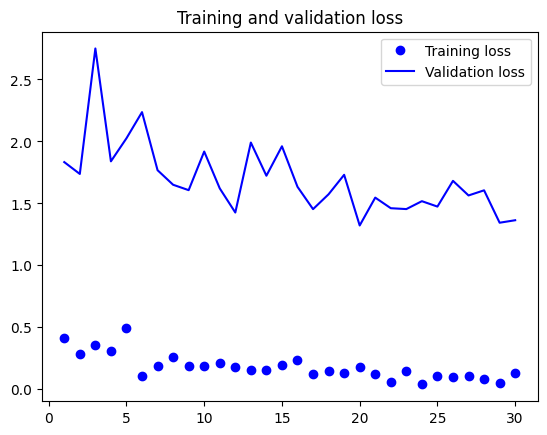

In [ ]:
model = keras.models.load_model("fine_tuning.keras")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

Aquí obtenemos una precisión de prueba del 97,8% (nuevamente, tus propios resultados pueden variar en un punto porcentual). En la competencia original de Kaggle relacionada con este conjunto de datos, este habría sido uno de los mejores resultados. Sin embargo, no es una comparación del todo justa, ya que usamos características preentrenadas que ya contenían conocimiento previo sobre gatos y perros, algo que los competidores no podían usar en ese momento.

Por el lado positivo, al aprovechar técnicas modernas de *deep learning*, logramos alcanzar este resultado utilizando solo una pequeña fracción de los datos de entrenamiento disponibles para la competencia (aproximadamente el 10%). ¡Hay una gran diferencia entre entrenar con 20,000 muestras frente a 2,000 muestras!

Ahora cuentas con un conjunto sólido de herramientas para abordar problemas de clasificación de imágenes, especialmente cuando se trata de conjuntos de datos pequeños.


## Resumen
- Las CNNs son el mejor tipo de modelo de aprendizaje automático para tareas de visión por computadora. Es posible entrenar uno desde cero incluso con un conjunto de datos muy pequeño, obteniendo resultados decentes.
- Las CNNs funcionan aprendiendo una jerarquía de patrones modulares y conceptos para representar el mundo visual.
- En un conjunto de datos pequeño, el principal problema será el sobreajuste. La ampliación de datos (*data augmentation*) es una forma poderosa de combatir el sobreajuste cuando trabajas con datos de imágenes.
- Es fácil reutilizar una CNN existente en un nuevo conjunto de datos mediante la extracción de características (*feature extraction*). Esta es una técnica valiosa para trabajar con conjuntos de datos de imágenes pequeños.
- Como complemento a la extracción de características, puedes usar el ajuste fino (*fine-tuning*), que adapta algunas de las representaciones previamente aprendidas por un modelo existente a un nuevo problema. Esto mejora aún más el rendimiento.
